<a href="https://colab.research.google.com/github/mynameissh/comvision/blob/P%26ID_drawings/%EC%A7%81%EC%A0%91_%EB%A7%8C%EB%93%A0_cnn%EB%AA%A8%EB%8D%B8_%ED%99%9C%EC%9A%A9%ED%95%9C_P%26id_symbol_%EB%B6%84%EB%A5%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [72]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [73]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

In [74]:
data_transforms = {
    'train': transforms.Compose([

        transforms.RandomVerticalFlip(p=0.5),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(25),
        transforms.Resize(200),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(200),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

In [75]:
data_dir = '/content/drive/MyDrive/dataset'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=8,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

(3, 228, 1810)
(228, 1810, 3)


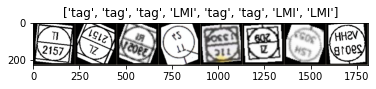

In [76]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    print(inp.numpy().shape)
    inp = inp.numpy().transpose((1, 2, 0))
    print(inp.shape)
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [87]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 224, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(224, 16, 5)
        self.conv3 = nn.Conv2d(16, 106, 5)

        self.fc1 = nn.Linear(106*24*24, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [89]:
for epoch in range(2):   # 데이터셋을 수차례 반복합니다.

    running_loss = 0.0
    for i, data in enumerate(dataloaders['train'], 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

torch.Size([8, 224, 110, 110])
torch.Size([8, 16, 53, 53])
torch.Size([8, 106, 24, 24])
torch.Size([8, 224, 110, 110])
torch.Size([8, 16, 53, 53])
torch.Size([8, 106, 24, 24])
torch.Size([8, 224, 110, 110])
torch.Size([8, 16, 53, 53])
torch.Size([8, 106, 24, 24])
torch.Size([8, 224, 110, 110])
torch.Size([8, 16, 53, 53])
torch.Size([8, 106, 24, 24])
torch.Size([8, 224, 110, 110])
torch.Size([8, 16, 53, 53])
torch.Size([8, 106, 24, 24])
torch.Size([8, 224, 110, 110])
torch.Size([8, 16, 53, 53])
torch.Size([8, 106, 24, 24])
torch.Size([8, 224, 110, 110])
torch.Size([8, 16, 53, 53])


KeyboardInterrupt: ignored

(3, 228, 1810)
(228, 1810, 3)


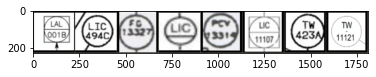

GroundTruth:  tensor(1) tensor(1) tensor(1) tensor(1)


In [79]:
dataiter = iter(dataloaders['val'])
images, labels = dataiter.next()

# 이미지를 출력합니다.
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

(3, 228, 1810)
(228, 1810, 3)


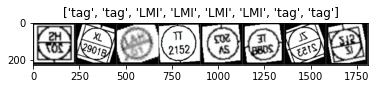

In [86]:
inputs, classes = next(iter(dataloaders['train']))

# 배치로부터 격자 형태의 이미지를 만든다.
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [90]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

In [92]:
outputs = net(images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))


torch.Size([8, 224, 110, 110])
torch.Size([8, 16, 53, 53])
torch.Size([8, 106, 24, 24])
Predicted:  tensor(1) tensor(1) tensor(1) tensor(1)


In [93]:
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in dataloaders['val']:
        images, labels = data
        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

torch.Size([8, 224, 110, 110])
torch.Size([8, 16, 53, 53])
torch.Size([8, 106, 24, 24])
torch.Size([8, 224, 110, 110])
torch.Size([8, 16, 53, 53])
torch.Size([8, 106, 24, 24])
torch.Size([8, 224, 110, 110])
torch.Size([8, 16, 53, 53])
torch.Size([8, 106, 24, 24])
torch.Size([8, 224, 110, 110])
torch.Size([8, 16, 53, 53])
torch.Size([8, 106, 24, 24])
torch.Size([8, 224, 110, 110])
torch.Size([8, 16, 53, 53])
torch.Size([8, 106, 24, 24])
torch.Size([8, 224, 110, 110])
torch.Size([8, 16, 53, 53])
torch.Size([8, 106, 24, 24])
torch.Size([8, 224, 110, 110])
torch.Size([8, 16, 53, 53])
torch.Size([8, 106, 24, 24])
torch.Size([8, 224, 110, 110])
torch.Size([8, 16, 53, 53])
torch.Size([8, 106, 24, 24])
torch.Size([8, 224, 110, 110])
torch.Size([8, 16, 53, 53])
torch.Size([8, 106, 24, 24])
torch.Size([8, 224, 110, 110])
torch.Size([8, 16, 53, 53])
torch.Size([8, 106, 24, 24])
torch.Size([8, 224, 110, 110])
torch.Size([8, 16, 53, 53])
torch.Size([8, 106, 24, 24])
torch.Size([8, 224, 110, 110])
t